In [1]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc

from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("C:/Users/fedor/.conda/envs/tf-gpu/Lib/site-packages/tensorflow/contrib/slim")

C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework

In [2]:
tf.reset_default_graph()
slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
print("starting the job...")

num_out = 5    #number ouf output parameters being predicted

global numpix_side 
numpix_side = 192   #number of image pixels on the side

global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)

global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2 

global min_unmasked_flux 
min_unmasked_flux = 0.75

#number of folders containing training or test data. If all 3 point to the same folder that's OK (only that folder will be used).
global num_data_dirs
num_data_dirs = 3

num_training_samples = 200

PATH_train = 'D:/'
PATH_test = 'D:/'

arcs_data_path_1 = PATH_train + 'lensed_images/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1

test_data_path_1 = PATH_test + 'lensed_images_test/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = PATH_train + 'lensed_images/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1

testlens_data_path_1 = PATH_test + 'lensed_images_test/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

#folder containing cosmic rays
CRay_data_path   = '../../data_Ensai/CosmicRays/'

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

starting the job...


In [4]:
exec(open("get_data.py").read())

In [5]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% MODEL DEFINITION

x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])   #placeholder for input image
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
x_image0 = tf.reshape(x, [-1,numpix_side,numpix_side,1])

# removing image intensity bias: filter image with a 4X4 filter and remove from image
MASK = tf.abs(tf.sign(x_image0))
XX =  x_image0 +  ( (1-MASK) * 1000.0)
bias_measure_filt = tf.constant((1.0/16.0), shape=[4, 4, 1, 1])
bias_measure = tf.nn.conv2d( XX , bias_measure_filt , strides=[1, 1, 1, 1], padding='VALID')
im_bias = tf.reshape( tf.reduce_min(bias_measure,axis=[1,2,3]) , [-1,1,1,1] )
x_image = x_image0 - (im_bias * MASK )

In [6]:
# construct models
exec(open("ensai_model.py").read())

In [7]:
import sys
print(sys.path)
sys.path.append("C:/Users/fedor/.conda/envs/tf-gpu/Lib/site-packages/tensorflow/contrib/slim")

['C:\\Users\\fedor\\For jupyter\\Ensai\\3. Getting parameters', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\python37.zip', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\DLLs', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu', '', 'C:\\Users\\fedor\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib\\site-packages', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib\\site-packages\\win32', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib\\site-packages\\win32\\lib', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib\\site-packages\\Pythonwin', 'C:\\Users\\fedor\\.conda\\envs\\tf-gpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\fedor\\.ipython']


In [12]:
with tf.variable_scope("ENSAI"):
    x_input = slim.conv2d(x_image, 3,(3,3),padding='same', scope = 'new')    # x has a dimension of (IMG_SIZE,IMG_SIZE,3) 
    y_out = model_9(x_input,scope="model_9")

In [14]:
variables_to_restore =  slim.get_variables_to_restore(exclude=['ENSAI/model_9/fc8', 'ENSAI/new',\
                                                               'ENSAI/model_9/fc7', 'ENSAI/model_9/fc6'])

In [15]:
variables_to_restore

[<tf.Variable 'ENSAI/model_9/conv1/weights:0' shape=(11, 11, 3, 64) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv2/weights:0' shape=(5, 5, 64, 192) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv2/biases:0' shape=(192,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv3/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv3/biases:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv4/weights:0' shape=(3, 3, 384, 384) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv4/biases:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv5/weights:0' shape=(3, 3, 384, 256) dtype=float32_ref>,
 <tf.Variable 'ENSAI/model_9/conv5/biases:0' shape=(256,) dtype=float32_ref>]

In [16]:
#Для VGG_16

# layer_include_conv = 'ENSAI/vgg_16/conv'
# layer_include_fc = 'ENSAI/vgg_16/fc'

# include_1 = [layer_include_conv + str(i) for i in range(1,6)]
# include_2 = [layer_include_fc + str(i) for i in range(6,8)]
# include = include_1 + include_2

# variables_to_restore =  slim.get_variables_to_restore(include=include)   #list of variables to save

# def rename_1(var):
#     return var.op.name[6:]

# def rename_2(var):
#     if 'conv' in var:
#         num_layer = var.split("conv",1)[1][:1]
#         if 'weights' in var:
#             return var.replace("conv" + num_layer, "conv" + num_layer + '/conv' + num_layer + '_1')
#         else:
#             return var.replace("conv" + num_layer, "conv" + num_layer + '/conv' + num_layer + '_2')
#     else:
#         return var

# variables_to_restore = [var for var in variables_to_restore if "Adam" not in var.name]
# variables_to_restore = {rename_1(var):var for var in variables_to_restore}
# variables_to_restore = {rename_2(var): variables_to_restore[var] for var in variables_to_restore}

In [17]:
def rename_2(var):
    return var.op.name.replace("ENSAI/model_9", "alexnet_v2")

variables_to_restore = {rename_2(var):var for var in variables_to_restore}

In [18]:
#variables_to_save =  slim.get_variables(scope="ENSAI/EN_Model" + str(model_num) )   #list of variables to save
#variables_to_restore = variables_to_save   #list of variables to restore (same as save here)
train_pars = variables_to_restore  #list of parameters to train

In [19]:
# #save_file =  "../data_Ensai/trained_weights/model_" + str(model_num) + ".ckpt"     #path of file to save
save_file = '../data_Ensai/trained_weights/model.ckpt'
restore_file = save_file   #path of network weights file to restore from

RESTORE = True
SAVE = True
restorer = tf.train.Saver(variables_to_restore)
# saver = tf.train.Saver(variables_to_save)

# ############## flipping and cost function
MeanSquareCost , y_out_flipped = cost_tensor(y_out)

In [20]:
variables_to_restore

{'alexnet_v2/conv1/weights': <tf.Variable 'ENSAI/model_9/conv1/weights:0' shape=(11, 11, 3, 64) dtype=float32_ref>,
 'alexnet_v2/conv1/biases': <tf.Variable 'ENSAI/model_9/conv1/biases:0' shape=(64,) dtype=float32_ref>,
 'alexnet_v2/conv2/weights': <tf.Variable 'ENSAI/model_9/conv2/weights:0' shape=(5, 5, 64, 192) dtype=float32_ref>,
 'alexnet_v2/conv2/biases': <tf.Variable 'ENSAI/model_9/conv2/biases:0' shape=(192,) dtype=float32_ref>,
 'alexnet_v2/conv3/weights': <tf.Variable 'ENSAI/model_9/conv3/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>,
 'alexnet_v2/conv3/biases': <tf.Variable 'ENSAI/model_9/conv3/biases:0' shape=(384,) dtype=float32_ref>,
 'alexnet_v2/conv4/weights': <tf.Variable 'ENSAI/model_9/conv4/weights:0' shape=(3, 3, 384, 384) dtype=float32_ref>,
 'alexnet_v2/conv4/biases': <tf.Variable 'ENSAI/model_9/conv4/biases:0' shape=(384,) dtype=float32_ref>,
 'alexnet_v2/conv5/weights': <tf.Variable 'ENSAI/model_9/conv5/weights:0' shape=(3, 3, 384, 256) dtype=float32_ref>

In [21]:
reader = tf.train.NewCheckpointReader(restore_file)
reader.get_variable_to_shape_map()

{'alexnet_v2/conv1/weights': [11, 11, 3, 64],
 'alexnet_v2/fc8/weights/RMSProp_1': [1, 1, 4096, 1001],
 'alexnet_v2/fc8/biases/RMSProp_1': [1001],
 'alexnet_v2/conv5/weights/RMSProp': [3, 3, 384, 256],
 'alexnet_v2/conv5/biases/RMSProp': [256],
 'alexnet_v2/conv1/biases': [64],
 'alexnet_v2/conv1/weights/RMSProp': [11, 11, 3, 64],
 'alexnet_v2/conv1/weights/RMSProp_1': [11, 11, 3, 64],
 'alexnet_v2/conv5/weights': [3, 3, 384, 256],
 'alexnet_v2/conv5/biases': [256],
 'alexnet_v2/conv1/biases/RMSProp': [64],
 'alexnet_v2/conv1/biases/RMSProp_1': [64],
 'alexnet_v2/conv2/biases/RMSProp': [192],
 'alexnet_v2/conv2/biases/RMSProp_1': [192],
 'alexnet_v2/conv2/biases': [192],
 'alexnet_v2/conv2/weights': [5, 5, 64, 192],
 'alexnet_v2/conv2/weights/RMSProp': [5, 5, 64, 192],
 'alexnet_v2/conv2/weights/RMSProp_1': [5, 5, 64, 192],
 'alexnet_v2/conv3/biases': [384],
 'alexnet_v2/conv3/biases/RMSProp': [384],
 'alexnet_v2/fc6/weights/RMSProp': [5, 5, 256, 4096],
 'alexnet_v2/conv3/weights': [3,

### Training

In [22]:
############### OPTIMIZER:
learning_rate = 1e-6
train_step = tf.train.AdamOptimizer(learning_rate).minimize(MeanSquareCost,var_list=train_pars)
##########################

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
num_batch_samples = 64
num_iterations = 1
min_eval_cost = 0.2
cycle_batch_size = 200
X = np.zeros((cycle_batch_size,numpix_side*numpix_side), dtype='float32') ;
Y = np.zeros((cycle_batch_size,num_out), dtype='float32' );
MAG = np.zeros((cycle_batch_size,1), dtype='float32' );

In [24]:
min_unmasked_flux = 0.98
num_test_samples = 1000 # number of test samples
max_num_test_samples = 1000

X_test = np.zeros((num_test_samples,numpix_side*numpix_side), dtype='float32'  );
Y_test = np.zeros((num_test_samples,num_out), dtype='float32' );
MAG_test = np.zeros((num_test_samples,1), dtype='float32' );
Predictions = np.zeros((num_test_samples , num_out ) , dtype='float32' )
# max_noise_rms = max_testnoise_rms

In [26]:
read_data_batch(X_test, Y_test, MAG_test, max_num_test_samples, 'test')

In [27]:
# vars_to_rename = {
#     "ENSAI/vgg_16/conv1/weights": "ENSAI/vgg_16/conv1/kernel",
#     "ENSAI/vgg_16/conv1/biases": "ENSAI/vgg_16/conv1/bias",
# }
# new_checkpoint_vars = {}
# reader = tf.train.NewCheckpointReader(restore_file)
# for old_name in reader.get_variable_to_shape_map():
#     if old_name in vars_to_rename:
#         new_name = vars_to_rename[old_name]
#     else:
#         new_name = old_name
#     new_checkpoint_vars[new_name] = tf.Variable(reader.get_tensor(old_name))

# init = tf.global_variables_initializer()
# restorer = tf.train.Saver(new_checkpoint_vars)

In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if RESTORE:
    restorer.restore(sess, restore_file)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../data_Ensai/trained_weights/model.ckpt


In [29]:
n = 0
ind_t = range(num_test_samples)
train_cost = 0
write_time = time.time()
start_time = time.time()

log_file = open("log_file.txt","w")
log_file.close()

In [36]:
model_num = '_AlexNet_reinforcment'
cycle_batch_size = 64
num_iterations = int(num_training_samples/cycle_batch_size)

In [37]:
num_training_samples

12306

In [38]:
for i_sample in range(1):
        if i_sample%1 == 0:

            max_noise_rms = max_trainoise_rms
            min_unmasked_flux = 0.75
            read_data_batch( X , Y , MAG , num_training_samples , 'train' )

        for i in range(num_iterations):
            n = n + 1

            if cycle_batch_size==num_batch_samples:
                ind = range(num_batch_samples)
            else:
                ind = np.random.randint(0, high=num_batch_samples, size=cycle_batch_size)

            xA = X[ind]
            yA = Y[ind]

        # once every 20 iterations evaluate things for the validation set.
        
            print_per = 20
            if n%print_per == 1:
                        gc.collect()
                        train_cost = sess.run(MeanSquareCost, feed_dict={x:xA, y_: yA} )

                        sum_rms = 0
                        eval_cost = 0
                        chunk_size = 50
                        num_chunks = int(num_test_samples/chunk_size)
                        for it in range(num_chunks):
                                eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
                                A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                                B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
                                Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
                                sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                                           Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
                        eval_cost = eval_cost / num_chunks
                        print("mod "+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )


            # show the iteration number, training cost, validation cost, and the average time per iteration for training
                        print("                                         %0.4d    %0.4d    %0.5f    %0.5f    %0.5f   %0.3f"%(i_sample,i,train_cost,eval_cost,min_eval_cost,(time.time()-start_time)/print_per)) 
                        start_time = time.time()
                        
                        log_file = open("log_file.txt","a")
                        log_file.write('%d ' % (i_sample) + ' '.join(map(str,sum_rms/num_chunks)) + ' %0.5f %0.5f\n' % (train_cost,eval_cost) )
                        log_file.close()               
                    
                        if  SAVE & (eval_cost<min_eval_cost) & (n>20): # save file when validation cost drops
                                print("saving weights to the disk (eval) ...")
                                save_path = saver.save(sess, save_file)
                                print("done.")
                        min_eval_cost = np.minimum(min_eval_cost,eval_cost)
            sess.run(train_step, feed_dict={x: xA, y_: yA})

mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0019    0.69404    0.61707    0.20000   16.173
mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0039    0.69221    0.61569    0.20000   0.727
mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0059    0.69032    0.61426    0.20000   0.730
mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0079    0.68839    0.61278    0.20000   0.725
mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0099    0.68643    0.61126    0.20000   0.724
mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]
                                         0000    0119    0.68445    0.60971    0.20000   0.726
mod _AlexNet_reinforcment, lr: 1e-06, [

In [40]:
sum_rms = 0
eval_cost = 0
chunk_size = 50
num_chunks = int(num_test_samples/chunk_size)
for it in range(num_chunks):
        eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
        A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
        B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
eval_cost = eval_cost / num_chunks
print("mod "+ str(model_num) + ", lr: " + str(learning_rate) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )

mod _AlexNet_reinforcment, lr: 1e-06, [0.8  0.33 0.35 0.17 0.16]


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'y (true)')

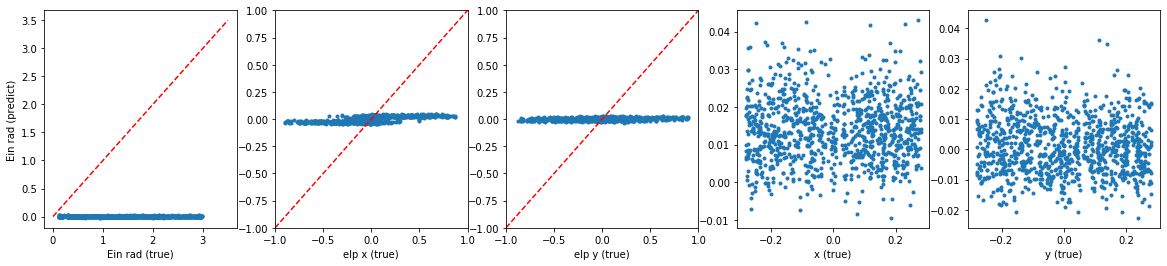

In [44]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y_test[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.5],[0 , 3.5],'--r')
plt.xlabel("Ein rad (true)")
plt.ylabel("Ein rad (predict)")
#plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y_test[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y_test[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)")
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y_test[:,3],Predictions[:,3],' .')
#plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)")
#plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y_test[:,4],Predictions[:,4],' .')
#plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)")
#plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])